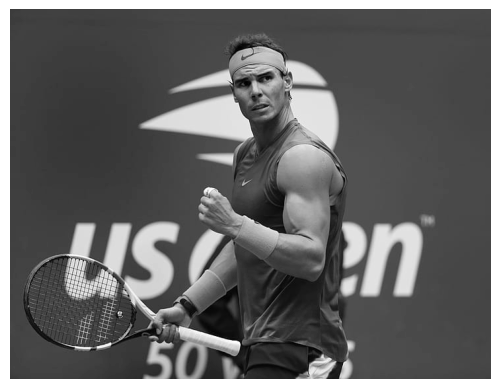

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image = cv2.imread("nadal2.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure()
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

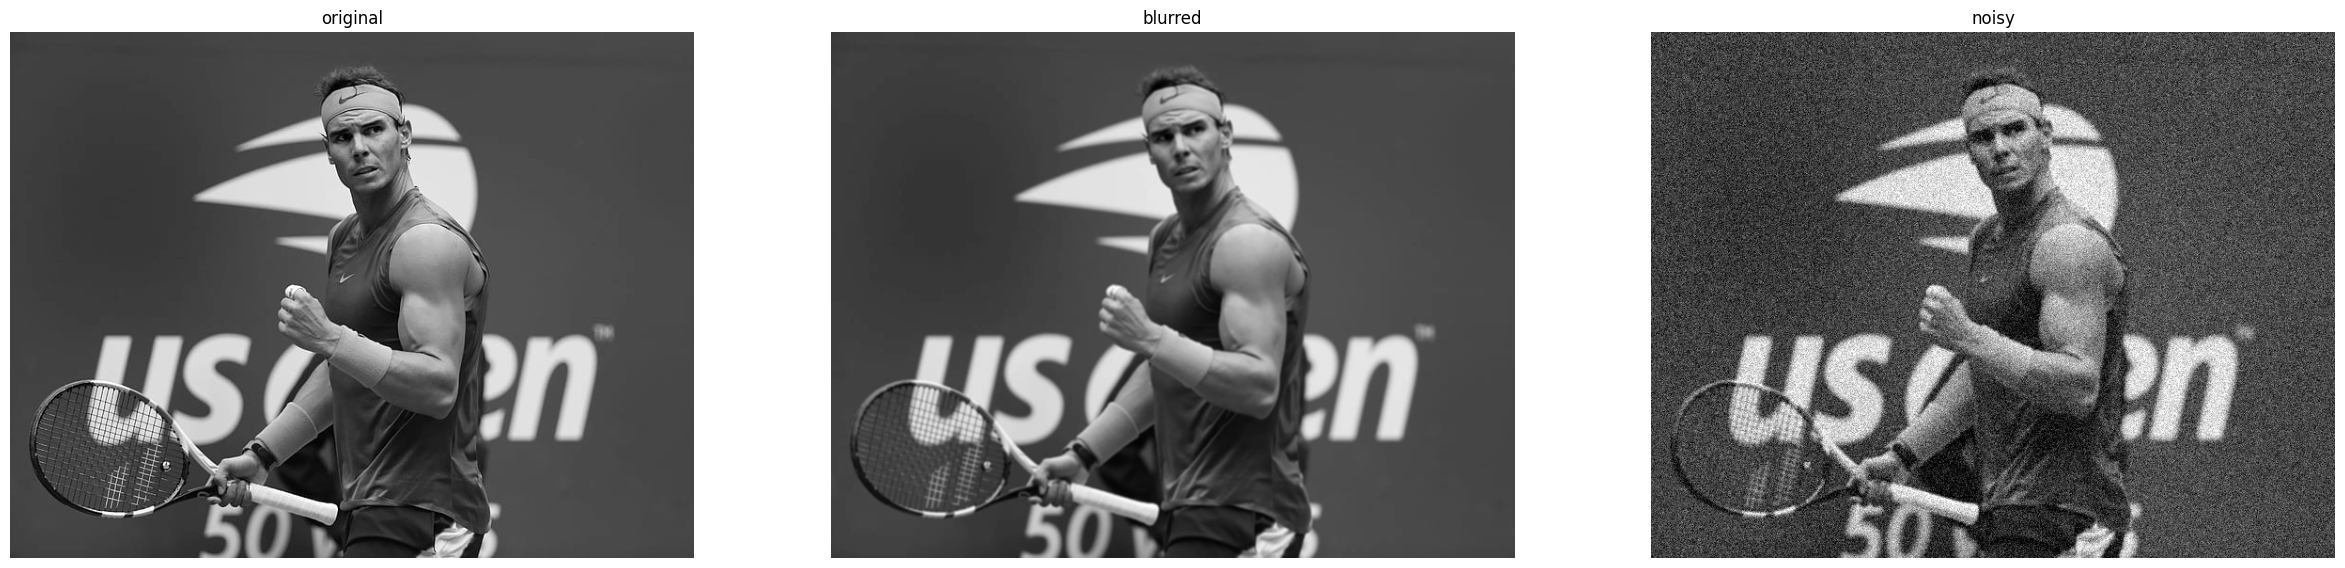

In [89]:
# image sensor simulation: LPF of gaussian type on image and add noise

k = (5,5)
gaussian_lpf = cv2.GaussianBlur(image, k, 0)

def add_awgn(image, mean=0, std=1):
    noise = np.random.normal(mean,std,image.shape).astype(np.uint8)
    img_noisy = cv2.add(image,noise)
    return img_noisy

noise_img = add_awgn(gaussian_lpf, mean=0, std=0.6).astype(np.float64)

noisy2 = random_noise(gaussian_lpf, mode='gaussian')

plt.figure(figsize=(30,40))
plt.subplot(1,3,1); plt.imshow(image, cmap='gray'); plt.title('original');plt.axis('off')
plt.subplot(1,3,2); plt.imshow(gaussian_lpf, cmap='gray'); plt.title('blurred');plt.axis('off')
plt.subplot(1,3,3); plt.imshow(noisy2, cmap='gray'); plt.title('noisy');plt.axis('off')
plt.show()

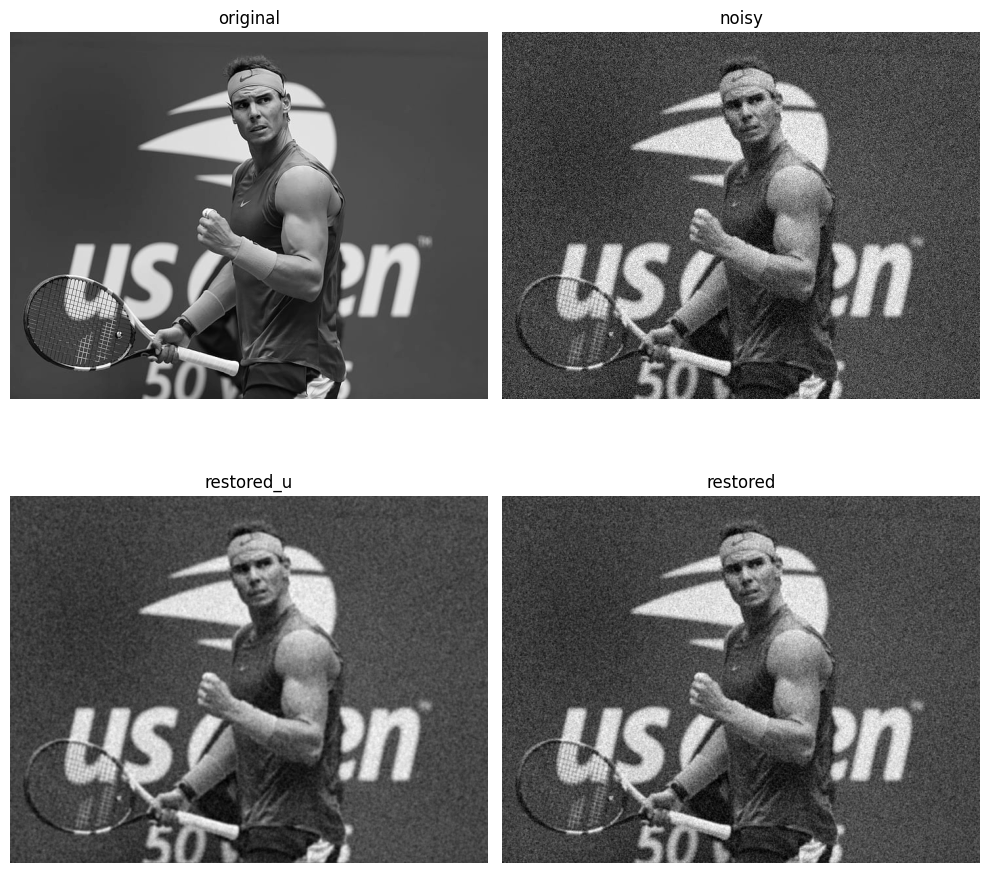

In [99]:
from skimage.io import imread
from skimage import color, data, restoration
from scipy.signal import convolve2d
from skimage.util import random_noise

k=1
psf = np.ones((k,k)) / (k*k)
restored_image, _ = restoration.unsupervised_wiener(noisy2, psf=psf)
restored_image2 = restoration.wiener(noisy2, psf=psf, balance=0.1)

restored_image = np.clip(restored_image * 255, 0, 255).astype(np.uint8)
restored_image2 = np.clip(restored_image2 * 255, 0, 255).astype(np.uint8)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1); plt.imshow(image, cmap='gray'); plt.title('original');plt.axis('off')
#plt.subplot(2,2,2); plt.imshow(gaussian_lpf, cmap='gray'); plt.title('blurred');plt.axis('off')
plt.subplot(2,2,2); plt.imshow(noisy2, cmap='gray'); plt.title('noisy');plt.axis('off')
plt.subplot(2,2,3); plt.imshow(restored_image, cmap='gray'); plt.title('restored_u');plt.axis('off')
plt.subplot(2,2,4); plt.imshow(restored_image2, cmap='gray'); plt.title('restored');plt.axis('off')
plt.tight_layout()
plt.show()

In [100]:
from skimage.metrics import peak_signal_noise_ratio

psnr0 = peak_signal_noise_ratio(image_true=image, image_test=gaussian_lpf)
psnr1 = peak_signal_noise_ratio(image_true=image, image_test=restored_image)
psnr2 = peak_signal_noise_ratio(image_true=image, image_test=restored_image2)

print(f"PSNR blur image: {psnr0:.3f}")
print(f"PSNR supervised: {psnr1:.3f}")
print(f"PSNR unsupervised: {psnr2:.3f}")

PSNR blur image: 30.275
PSNR supervised: 26.528
PSNR unsupervised: 24.377


In [78]:
np.dtype(image[0,0])
np.dtype(noisy2[0,0])

dtype('float64')

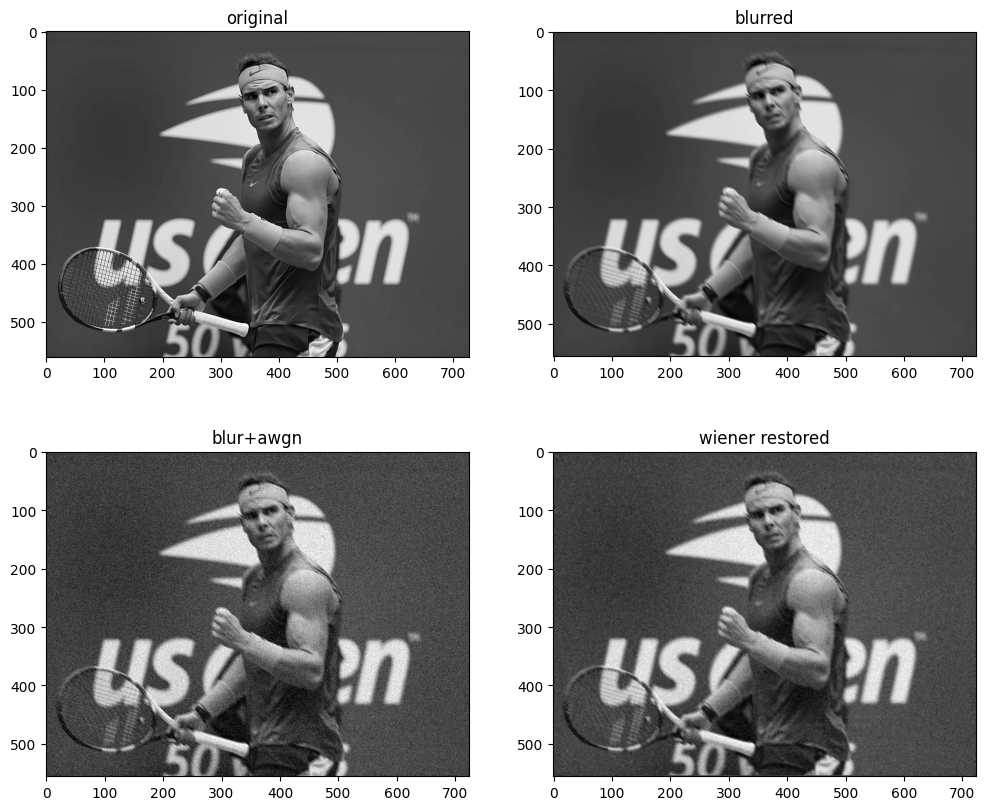

In [154]:
from scipy.signal import convolve2d
from scipy.stats import norm
from numpy.fft import fft2, ifft2

def blur(image, kernel_size=3):
    kernel = np.eye(kernel_size)/kernel_size
    blurred_img = np.copy(image)
    blurred_img = convolve2d(blurred_img, kernel, mode='valid')
    return blurred_img

def add_awgn(image, sigma):
    noisy_img = image + np.random.normal(0,sigma,np.shape(image))
    noisy_img[noisy_img < 0] = 0; noisy_img[noisy_img > 255] = 255
    return noisy_img

def kernel_g(kernel_size=3):
    sigma = kernel_size / 3  # Standard deviation
    x = np.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    kernel_1d = norm.pdf(x, scale=sigma)
    kernel_1d = kernel_1d / kernel_1d.sum()  # Normalizare
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    return kernel_2d / kernel_2d.sum() 

def wiener_restore(image, kernel, K):
    kernel = kernel / np.sum(kernel)
    spectra = fft2(image)
    kernel = fft2(kernel, s = image.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    spectra = spectra * kernel
    inverse = np.abs(ifft2(spectra))
    return inverse


blurred_img = blur(image, kernel_size = 5)
noisy_img = add_awgn(blurred_img, sigma = 15)
kernel = kernel_g(3)
filtered_img = wiener_restore(noisy_img, kernel, K = 50)

display = [image, blurred_img, noisy_img, filtered_img]
label = ['original', 'blurred', 'blur+awgn', 'wiener restored']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
	fig.add_subplot(2, 2, i+1)
	plt.imshow(display[i], cmap = 'gray')
	plt.title(label[i])
    
plt.show()

In [103]:
!pip install scipy

In [150]:
image_rsz = cv2.resize(image, (724, 556), interpolation = cv2.INTER_LINEAR)

blurred_img = np.clip(blurred_img * 255, 0, 255).astype(np.uint8)
filtered_img = np.clip(filtered_img * 255, 0, 255).astype(np.uint8)

psnr0 = peak_signal_noise_ratio(image_true=image_rsz, image_test=blurred_img)
psnr1 = peak_signal_noise_ratio(image_true=image_rsz, image_test=filtered_img)

print(f"PSNR blur image: {psnr0:.3f}")
print(f"PSNR supervised: {psnr1:.3f}")

PSNR blur image: 3.275
PSNR supervised: 3.607


In [149]:
np.dtype(filtered_img[0,0])

dtype('float64')